# ECE421 Assignment 2: Neural Networks

### Group Members
1. Low Weng Fei (1005644705)
2. Hema Rajesh Nadella (1005324837)

---

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import tensorflow as tf

# Load the data
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

In [5]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainTarget, validTarget, testTarget = convertOneHot(trainTarget, validTarget, testTarget)

X_train = trainData
Y_train = trainTarget
X_valid = validData
Y_valid = validTarget
X_test = testData
Y_test = testTarget

## 2. Neural Networks in Tensorflow

### 2.1 Model implementation

In [2]:
def buildGraph(learning_rate, l2_reg, keep_prob):
    tf.set_random_seed(521)
    tf.reset_default_graph()
    
    X_ts = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28, 1), name="X_ts")
    Y_ts = tf.placeholder(dtype=tf.float32, shape=(None, 10), name="Y_ts")
    
    conv2d_filter_ts = tf.get_variable("conv2d_filter_ts", shape=(3, 3, 1, 32), 
                                       initializer=tf.initializers.glorot_normal(), 
                                       regularizer=tf.nn.l2_loss, validate_shape=False)
    conv2d_biases_ts = tf.get_variable("conv2d_biases_ts", shape=(32), 
                                       initializer=tf.initializers.zeros(), 
                                       regularizer=None, validate_shape=False)
    flow_ts = tf.nn.conv2d(X_ts, conv2d_filter_ts, (1, 1, 1, 1), "SAME")
    flow_ts = tf.nn.bias_add(flow_ts, conv2d_biases_ts)
    flow_ts = tf.nn.relu(flow_ts)
    
    batch_mean_ts, batch_var_ts = tf.nn.moments(flow_ts, axes=[0])
    flow_ts = tf.nn.batch_normalization(flow_ts, batch_mean_ts, batch_var_ts, None, None, 0.001)  
    
    flow_ts = tf.nn.max_pool(flow_ts, (1, 2, 2, 1), (1, 2, 2, 1), "SAME")
    flow_ts = tf.manip.reshape(flow_ts, [-1, 6272])   # flatten layer: 6272 = 28/2[max pool] * 28/2[max pool] * 32[conv filter] 
    
    dense1_weights_ts = tf.get_variable("dense1_weights_ts", shape=(6272, 784), 
                                        initializer=tf.initializers.glorot_normal(), 
                                        regularizer=tf.nn.l2_loss, validate_shape=False)
    dense1_biases_ts = tf.get_variable("dense1_biases_ts", shape=(784), 
                                       initializer=tf.initializers.zeros(), 
                                       regularizer=None, validate_shape=False)
    flow_ts = tf.nn.xw_plus_b(flow_ts, dense1_weights_ts, dense1_biases_ts)
    flow_ts = tf.nn.dropout(flow_ts, keep_prob)
    flow_ts = tf.nn.relu(flow_ts)
    
    dense2_weights_ts = tf.get_variable("dense2_weights_ts", shape=(784, 10), 
                                        initializer=tf.initializers.glorot_normal(), 
                                        regularizer=tf.nn.l2_loss, validate_shape=False)
    dense2_biases_ts = tf.get_variable("dense2_biases_ts", shape=(10), 
                                       initializer=tf.initializers.zeros(), 
                                       regularizer=None, validate_shape=False)
    Y_hat_logits_ts = tf.nn.xw_plus_b(flow_ts, dense2_weights_ts, dense2_biases_ts, name="Y_hat_logits_ts")
    Y_hat_ts = tf.nn.softmax(Y_hat_logits_ts, name="Y_hat_ts")
    
    l2_reg_ts = tf.constant(l2_reg, shape=(), name="l2_reg_ts", verify_shape=True)
    reg_loss_ts = tf.math.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES), name="reg_loss_ts")
    non_reg_loss_ts = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_ts, logits=Y_hat_logits_ts,
                                                                                name="non_reg_loss_ts"))
    loss_ts = non_reg_loss_ts + l2_reg_ts * reg_loss_ts

    adam_optimizer_ts = tf.train.AdamOptimizer(learning_rate, name="adam_optimizer_ts")
    training_op = adam_optimizer_ts.minimize(loss_ts, name="training_op")
    
    return conv2d_filter_ts, conv2d_biases_ts, dense1_weights_ts, dense1_biases_ts, dense2_weights_ts, dense2_biases_ts, \
           X_ts, Y_ts, Y_hat_ts, loss_ts, training_op

def add_channel_dim(X):
    return np.reshape(X, (*X.shape, 1))

def sgd_adam(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, epochs, minibatch_size, learning_rate, l2_reg, keep_prob):
    conv2d_filter_ts, conv2d_biases_ts, \
    dense1_weights_ts, dense1_biases_ts, \
    dense2_weights_ts, dense2_biases_ts, \
    X_ts, Y_ts, Y_hat_ts, loss_ts, training_op = buildGraph(learning_rate, l2_reg, keep_prob)
    init = tf.initializers.global_variables()
    
    # add channels
    X_train = add_channel_dim(X_train)
    X_valid = add_channel_dim(X_valid)
    X_test = add_channel_dim(X_test)
    
    N = X_train.shape[0]
    num_batches = N // minibatch_size 
    loss_train = np.empty(epochs)
    loss_valid = np.empty(epochs)
    loss_test = np.empty(epochs)
    accuracy = np.empty(epochs)

    with tf.Session() as sess:
        init.run()
        index = np.arange(N)
        for iteration in range(epochs):
            shuffled_index = np.random.permutation(index)
            X_train_shuffled = X_train[shuffled_index]
            Y_train_shuffled = Y_train[shuffled_index]
            
            for batch_index in range(num_batches):
                start_index = batch_index * minibatch_size
                end_index = start_index + minibatch_size
                X_train_batch = X_train_shuffled[start_index : end_index]
                Y_train_batch = Y_train_shuffled[start_index : end_index]
                training_op.run(feed_dict={X_ts: X_train_batch, Y_ts: Y_train_batch})
                        
            loss_train[iteration] = loss_ts.eval(feed_dict={X_ts: X_train, Y_ts: Y_train})
            loss_valid[iteration] = loss_ts.eval(feed_dict={X_ts: X_valid, Y_ts: Y_valid})
            loss_test[iteration] = loss_ts.eval(feed_dict={X_ts: X_test, Y_ts: Y_test})
            
            Y_hat_test = Y_hat_ts.eval(feed_dict={X_ts: X_test})
            accuracy[iteration] = np.mean(np.argmax(Y_test, axis=1) == np.argmax(Y_hat_test, axis=1))
            
            if (iteration % 5 == 0):
                print("Epoch {} - Training, Validation, Testing Loss: {} {} {}"
                      .format(iteration, loss_train[iteration], loss_valid[iteration], loss_test[iteration]))
        conv2d_filter = conv2d_filter_ts.eval()
        conv2d_biases = conv2d_biases_ts.eval()
        dense1_weights = dense1_weights_ts.eval()
        dense1_biases = dense1_biases_ts.eval()
        dense2_weights = dense2_weights_ts.eval()
        dense2_biases = dense2_biases_ts.eval()

    plt.figure()
    plt.plot(loss_train, label="Training Loss")
    plt.plot(loss_valid, label="Validation Loss")
    plt.plot(loss_test, label="Testing Loss")
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(accuracy, label="Accuracy")
    plt.legend()
    plt.show()
        
    print("Final Training Loss", loss_train[-1])
    print("Final Validation Loss", loss_valid[-1])
    print("Final Testing Loss", loss_test[-1])
    print("Final Testing Accuracy:", accuracy[-1])
    
    return conv2d_filter, conv2d_biases, dense1_weights, dense1_biases, dense2_weights, dense2_biases

### 2.2 Model Training

Epoch 0 - Training, Validation, Testing Loss: 0.13280172646045685 0.29562246799468994 0.2983432710170746
Epoch 5 - Training, Validation, Testing Loss: 0.015885617583990097 0.3121480345726013 0.31956958770751953
Epoch 10 - Training, Validation, Testing Loss: 0.011633084155619144 0.34632962942123413 0.35923531651496887
Epoch 15 - Training, Validation, Testing Loss: 0.01865733042359352 0.40080127120018005 0.45407480001449585
Epoch 20 - Training, Validation, Testing Loss: 0.005372659303247929 0.3940433859825134 0.42678457498550415
Epoch 25 - Training, Validation, Testing Loss: 0.0023829604033380747 0.3867036998271942 0.4073726534843445
Epoch 30 - Training, Validation, Testing Loss: 0.003326907753944397 0.4123970568180084 0.4331515431404114
Epoch 35 - Training, Validation, Testing Loss: 0.0018698942149057984 0.40582773089408875 0.4219741225242615
Epoch 40 - Training, Validation, Testing Loss: 0.0035280960146337748 0.43904733657836914 0.4397219121456146
Epoch 45 - Training, Validation, Testi

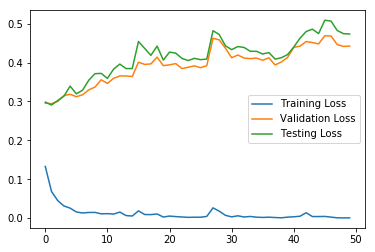

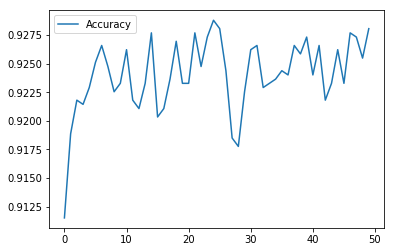

Final Training Loss 0.0007548911962658167
Final Validation Loss 0.44225171208381653
Final Testing Loss 0.4733103811740875
Final Testing Accuracy: 0.9280469897209985


In [9]:
conv2d_filter, conv2d_biases, \
dense1_weights, dense1_biases, \
dense2_weights, dense2_biases = sgd_adam(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, 
                                epochs=50, minibatch_size=32, learning_rate=1e-4, l2_reg=0.0, keep_prob=1.0)

### 2.3 Hyperparameter Investigation

#### 1. L2 Normalization

(i) $\lambda$ = 0.01

Epoch 0 - Training, Validation, Testing Loss: 4.810044288635254 4.951680660247803 4.964076995849609
Epoch 5 - Training, Validation, Testing Loss: 0.7871054410934448 1.0036040544509888 1.0243275165557861
Epoch 10 - Training, Validation, Testing Loss: 0.29256758093833923 0.5177613496780396 0.5319761633872986
Epoch 15 - Training, Validation, Testing Loss: 0.23033462464809418 0.4450192451477051 0.4700050354003906
Epoch 20 - Training, Validation, Testing Loss: 0.21603965759277344 0.42827823758125305 0.4355247914791107
Epoch 25 - Training, Validation, Testing Loss: 0.20564410090446472 0.40578389167785645 0.4282453656196594
Epoch 30 - Training, Validation, Testing Loss: 0.20404426753520966 0.41031408309936523 0.425915002822876
Epoch 35 - Training, Validation, Testing Loss: 0.20200717449188232 0.4061063528060913 0.43681928515434265
Epoch 40 - Training, Validation, Testing Loss: 0.18659178912639618 0.3903244733810425 0.40831440687179565
Epoch 45 - Training, Validation, Testing Loss: 0.176840946

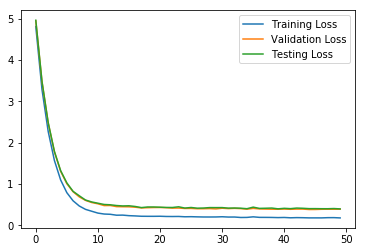

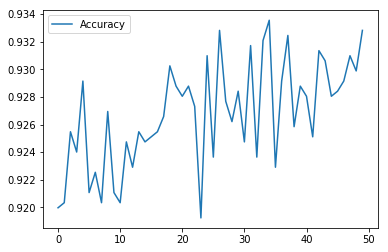

Final Training Loss 0.17577366530895233
Final Validation Loss 0.3869648277759552
Final Testing Loss 0.3944230079650879
Final Testing Accuracy: 0.9328193832599119


In [11]:
conv2d_filter, conv2d_biases, \
dense1_weights, dense1_biases, \
dense2_weights, dense2_biases = sgd_adam(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, 
                                         epochs=50, minibatch_size=32, learning_rate=1e-4, l2_reg=0.01, keep_prob=1.0)

(ii) $\lambda$ = 0.1

Epoch 0 - Training, Validation, Testing Loss: 9.812353134155273 9.895491600036621 9.897001266479492
Epoch 5 - Training, Validation, Testing Loss: 0.6592352390289307 0.7120156288146973 0.7123526334762573
Epoch 10 - Training, Validation, Testing Loss: 0.6193450689315796 0.6570038795471191 0.6545947790145874
Epoch 15 - Training, Validation, Testing Loss: 0.5918107032775879 0.6437926292419434 0.6368200182914734
Epoch 20 - Training, Validation, Testing Loss: 0.5771467685699463 0.6294329166412354 0.6221544146537781
Epoch 25 - Training, Validation, Testing Loss: 0.5778770446777344 0.6256427764892578 0.6247149705886841
Epoch 30 - Training, Validation, Testing Loss: 0.5593273639678955 0.6079065799713135 0.6067006587982178
Epoch 35 - Training, Validation, Testing Loss: 0.5686707496643066 0.6130232810974121 0.6043302416801453
Epoch 40 - Training, Validation, Testing Loss: 0.5522429943084717 0.6004956960678101 0.6012343764305115
Epoch 45 - Training, Validation, Testing Loss: 0.5498771667480469 0.5

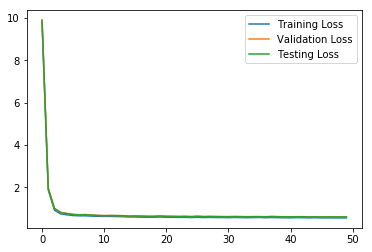

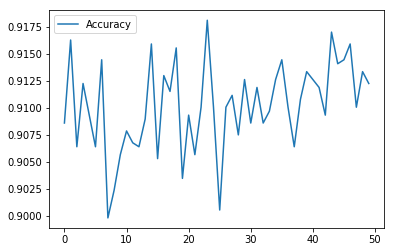

Final Training Loss 0.5498209595680237
Final Validation Loss 0.5993360280990601
Final Testing Loss 0.5957262516021729
Final Testing Accuracy: 0.9122613803230544


In [8]:
conv2d_filter, conv2d_biases, \
dense1_weights, dense1_biases, \
dense2_weights, dense2_biases = sgd_adam(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, 
                                         epochs=50, minibatch_size=32, learning_rate=1e-4, l2_reg=0.1, keep_prob=1.0)

(iii) $\lambda$ = 0.5

Epoch 0 - Training, Validation, Testing Loss: 18.142911911010742 18.179569244384766 18.159242630004883
Epoch 5 - Training, Validation, Testing Loss: 1.2567540407180786 1.2740788459777832 1.2670623064041138
Epoch 10 - Training, Validation, Testing Loss: 1.2148058414459229 1.2337281703948975 1.2151330709457397
Epoch 15 - Training, Validation, Testing Loss: 1.194035291671753 1.2173367738723755 1.2027450799942017
Epoch 20 - Training, Validation, Testing Loss: 1.1746997833251953 1.198720097541809 1.1800236701965332
Epoch 25 - Training, Validation, Testing Loss: 1.1971755027770996 1.2207231521606445 1.1981929540634155
Epoch 30 - Training, Validation, Testing Loss: 1.1561505794525146 1.1743693351745605 1.1620453596115112
Epoch 35 - Training, Validation, Testing Loss: 1.1570982933044434 1.1765764951705933 1.1661953926086426
Epoch 40 - Training, Validation, Testing Loss: 1.146610140800476 1.1664258241653442 1.1550992727279663
Epoch 45 - Training, Validation, Testing Loss: 1.162017583847046 1.18

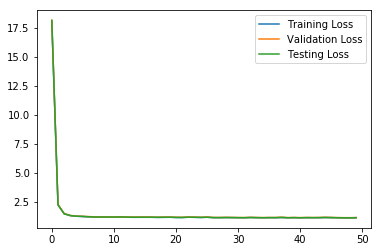

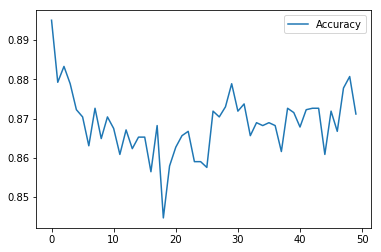

Final Training Loss 1.1530431509017944
Final Validation Loss 1.1722817420959473
Final Testing Loss 1.1596368551254272
Final Testing Accuracy: 0.8711453744493393


In [14]:
conv2d_filter, conv2d_biases, \
dense1_weights, dense1_biases, \
dense2_weights, dense2_biases = sgd_adam(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, 
                                epochs=50, minibatch_size=32, learning_rate=1e-4, l2_reg=0.5, keep_prob=1.0)

> From the three neural network models trained above with different regularization hyperparameters $\lambda$, it can be seen that the test accuracy improves when $\lambda$ is well chosen ($\lambda$ = 0.01 in this case), where a well balanced bias-variance tradeoff is attained.

#### 2. Dropout

(i) $p$ = 0.9

Epoch 0 - Training, Validation, Testing Loss: 0.16111402213573456 0.3124808073043823 0.3052413761615753
Epoch 5 - Training, Validation, Testing Loss: 0.02110767737030983 0.3046465516090393 0.33767470717430115
Epoch 10 - Training, Validation, Testing Loss: 0.012246507219970226 0.3416939973831177 0.3621978759765625
Epoch 15 - Training, Validation, Testing Loss: 0.010905163362622261 0.35870417952537537 0.39117681980133057
Epoch 20 - Training, Validation, Testing Loss: 0.013317877426743507 0.41613849997520447 0.4404226839542389
Epoch 25 - Training, Validation, Testing Loss: 0.007557520177215338 0.4190612733364105 0.4352899491786957
Epoch 30 - Training, Validation, Testing Loss: 0.0027096725534647703 0.4226393699645996 0.47356557846069336
Epoch 35 - Training, Validation, Testing Loss: 0.006497299298644066 0.4485303461551666 0.4921983778476715
Epoch 40 - Training, Validation, Testing Loss: 0.0033222748897969723 0.43145954608917236 0.4758560359477997
Epoch 45 - Training, Validation, Testing L

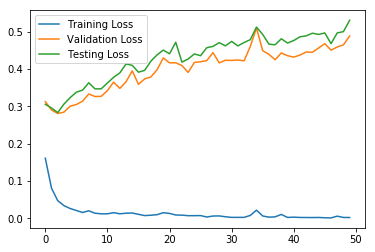

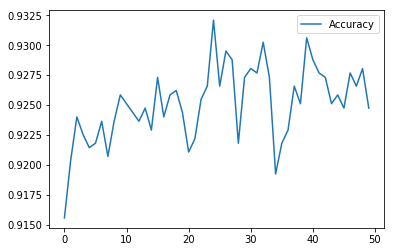

Final Training Loss 0.0024143799673765898
Final Validation Loss 0.48793163895606995
Final Testing Loss 0.5301170945167542
Final Testing Accuracy: 0.9247430249632893


In [12]:
conv2d_filter, conv2d_biases, \
dense1_weights, dense1_biases, \
dense2_weights, dense2_biases = sgd_adam(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, 
                                epochs=50, minibatch_size=32, learning_rate=1e-4, l2_reg=0.0, keep_prob=0.9)

(ii) $p$ = 0.75

Epoch 0 - Training, Validation, Testing Loss: 0.22269494831562042 0.3598399758338928 0.36667612195014954
Epoch 5 - Training, Validation, Testing Loss: 0.03520210087299347 0.31998327374458313 0.3551938235759735
Epoch 10 - Training, Validation, Testing Loss: 0.02112579345703125 0.34716886281967163 0.39678770303726196
Epoch 15 - Training, Validation, Testing Loss: 0.010961895808577538 0.3838638365268707 0.4026755094528198
Epoch 20 - Training, Validation, Testing Loss: 0.00920849945396185 0.4170804023742676 0.41823768615722656
Epoch 25 - Training, Validation, Testing Loss: 0.008489563129842281 0.4307710826396942 0.45337146520614624
Epoch 30 - Training, Validation, Testing Loss: 0.004818918649107218 0.4302419424057007 0.4347767233848572
Epoch 35 - Training, Validation, Testing Loss: 0.009378503076732159 0.4687628448009491 0.46085166931152344
Epoch 40 - Training, Validation, Testing Loss: 0.008187023922801018 0.47172030806541443 0.4700144827365875
Epoch 45 - Training, Validation, Testing Los

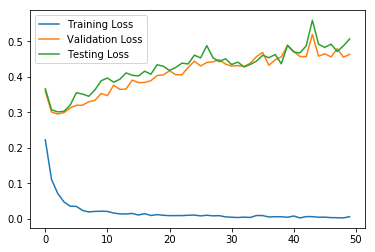

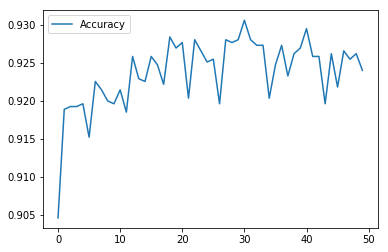

Final Training Loss 0.006468426436185837
Final Validation Loss 0.4633743464946747
Final Testing Loss 0.5070071816444397
Final Testing Accuracy: 0.9240088105726872


In [10]:
conv2d_filter, conv2d_biases, \
dense1_weights, dense1_biases, \
dense2_weights, dense2_biases = sgd_adam(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, 
                                epochs=50, minibatch_size=32, learning_rate=1e-4, l2_reg=0.0, keep_prob=0.75)

(iii) $p$ = 0.5

Epoch 0 - Training, Validation, Testing Loss: 0.2632317841053009 0.3833896517753601 0.3698742389678955
Epoch 5 - Training, Validation, Testing Loss: 0.053925756365060806 0.3181087374687195 0.3398953676223755
Epoch 10 - Training, Validation, Testing Loss: 0.030858583748340607 0.3702377378940582 0.38019973039627075
Epoch 15 - Training, Validation, Testing Loss: 0.024924717843532562 0.4028249979019165 0.40810427069664
Epoch 20 - Training, Validation, Testing Loss: 0.016432013362646103 0.4132624566555023 0.4385222792625427
Epoch 25 - Training, Validation, Testing Loss: 0.012151137925684452 0.4619365930557251 0.4549989104270935
Epoch 30 - Training, Validation, Testing Loss: 0.009026608429849148 0.4764406681060791 0.48572513461112976
Epoch 35 - Training, Validation, Testing Loss: 0.00976940430700779 0.4773062467575073 0.47961366176605225
Epoch 40 - Training, Validation, Testing Loss: 0.011972482316195965 0.478597491979599 0.49757298827171326
Epoch 45 - Training, Validation, Testing Loss: 0.0

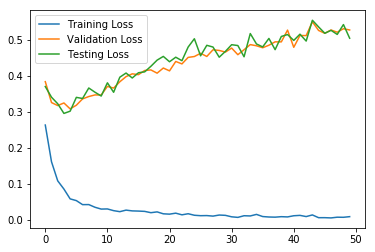

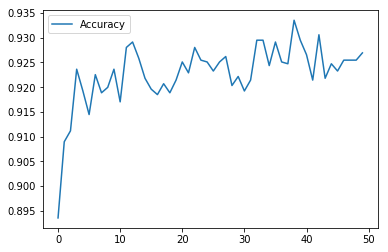

Final Training Loss 0.009482490830123425
Final Validation Loss 0.52652508020401
Final Testing Loss 0.5036869645118713
Final Testing Accuracy: 0.9269456681350955


In [13]:
conv2d_filter, conv2d_biases, \
dense1_weights, dense1_biases, \
dense2_weights, dense2_biases = sgd_adam(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, 
                                epochs=50, minibatch_size=32, learning_rate=1e-4, l2_reg=0.0, keep_prob=0.5)